<a href="https://colab.research.google.com/github/YehezkelShay/DataCamp/blob/master/Bicycles_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import lightgbm 
from sklearn.datasets import make_friedman2, make_friedman1, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import lightgbm
from sklearn.metrics import mean_squared_error
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import os
from google.colab import files


In [0]:
df2 = files.upload()
import io

Saving data.csv to data.csv


In [0]:
df= pd.read_csv(io.BytesIO(df2['data.csv']))

In [0]:
from datetime import datetime
df['datetime']= pd.to_datetime(df['datetime']) 
#df['date']= df['datetime'].dt.date


In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
dummy_weather = pd.get_dummies(df['weather'])
dummy_weather = dummy_weather.set_axis(['weather1','weather2','weather3','weather4'], axis=1, inplace=False)
df=df.join(dummy_weather, how='outer')
df[['humidity','season','holiday','workingday','temp','atemp','windspeed','year','month','day','hour','weather1','weather2','weather3','weather4']]=scaler.fit_transform(df[['humidity','season','holiday','workingday','temp','atemp','windspeed','year','month','day','hour','weather1','weather2','weather3','weather4']])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 0 to 10885
Data columns (total 20 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null float64
holiday       10886 non-null float64
workingday    10886 non-null float64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null float64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
year          10886 non-null float64
month         10886 non-null float64
day           10886 non-null float64
hour          10886 non-null float64
weather1      10886 non-null float64
weather2      10886 non-null float64
weather3      10886 non-null float64
weather4      10886 non-null float64
dtypes: datetime64[ns](1), float64(15), int64(4)
memory usage: 2.1 MB


In [0]:
# train-validation split
X = df.drop(['weather','temp','datetime','count','casual','registered'], axis = 1)  # independent columns
y = df[['count','casual','registered']]
X_train, X_test, y_train_all, y_test_all = train_test_split(X, y, test_size=0.09911813338232592, random_state=42)
# test set for generalization of scores['count','casual','registered']

y_train = y_train_all[['registered']]
y_test = y_test_all[['registered']]
y_valid = y_test_all[['registered']]
X_valid=X_test

In [0]:
## Plotting helper functions

def plot_residual_distribution(model):
    """
    Density plot of residuals (y_true - y_pred) for testation set for given model 
    """
    ax = sns.distplot(y_test.values.ravel() - model.predict(X_test), hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
    title = ax.set_title('Kernel density of residuals', size=15)
    
    
def plot_scatter_pred_actual(model):
    """
    Scatter plot of predictions from given model vs true target variable from testation set
    """
    ax = sns.scatterplot(x=model.predict(X_test), y = y_test)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Actuals')
    title = ax.set_title('Actual vs Prediction scatter plot', size=15)

In [0]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -1*residual, 100*residual)
    hess = np.where(residual<0, -1, 100)
    return grad, hess

def custom_asymmetric_eval(y_true, y_pred):
    residual = (y_true.values.ravel() - y_pred).astype("float")
    loss = np.where(residual < 0, (residual), 100*(residual))
    return "custom_asymmetric_eval", np.mean(loss), False

In [0]:
# make new model on new value
gbm3 = lightgbm.LGBMRegressor(random_state=33)
gbm3.set_params(**{'objective': custom_asymmetric_objective}, metrics = ["mse", 'mae'])

gbm3.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='l2',
    verbose=False,
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              metrics=['mse', 'mae'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=31,
              objective=<function custom_asymmetric_objective at 0x7fd92631a8c8>,
              random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
y_test_all[['registered']].values.ravel() -gbm3.predict(X_test)


array([1752758.7102504 , 1000325.68161854, 2389597.6641028 , ...,
       4849462.52342966, 5353977.69498845, 1000414.68161854])

In [0]:
plot_scatter_pred_actual(gbm3)


ValueError: ignored

MSE is 8118125629384.273


-2107535.199129052

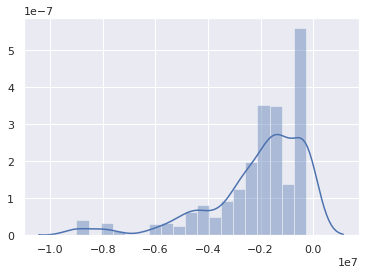

In [0]:
X_predict=gbm3.predict(X_test)
print(f"MSE is {mean_squared_error(y_test_all[['registered']], X_predict)}")
sns.distplot(X_predict)
X_predict.mean()